In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from copy import deepcopy
import matplotlib
import seaborn as sns
from scipy.special import logsumexp
import scipy
from lib import mixture_gaussians, entropy_mixture, reshape12, bootstrap



In [2]:

nchains = 800 #number of chains
n_samples_vec = [100,500,1000,2000,5000,10000,15000] #number of samples
n_sim = 20 #number of simulations for chains

ll = [0.3, 0.5, 0.7] #number of ratios between n and m. Notice for plots only 0.5 will be required
noise_levels =[0.1, 1.0] #number of noise levels 
noise_base = 1.0 #noise of the base distribution
ds = [1,5,10] #dimensions

nn = len(n_samples_vec)



In [4]:
#Load all npy files


sink = np.nan*np.zeros((nchains, n_sim, nn, len(ll), len(ds), len(noise_levels)))
sink_ind = np.nan*np.zeros((nchains, n_sim,nn, len(ll), len(ds), len(noise_levels)))
MC = np.nan*np.zeros((nchains, n_sim, nn, len(ll), len(ds), len(noise_levels)))

path = './Results/'
di = os.listdir(path)

for dd in range(len(di)):

    s = di[dd]
  
    if(s[0]=='c'):

        indnl = s.index('noise_level')
        indnb = s.index('noise_base')
        indd = s.index('d')

        indcolon=s.index('.npy')
        chain = int(s[2:indnl-1])-1
        nl = np.where(int(float(s[indnl+12:indnb-1]))==np.array(noise_levels).astype(int))[0][0]
        
        d = np.where(int(s[indd+2:indcolon])==np.array(ds).astype(int))[0][0]
        data = np.load(path + s,allow_pickle=True)
        sink[chain, :, :,:, d, nl] = data.item()['sink'].transpose([2,1,0])
        sink_ind[chain, :, :,:, d, nl] = data.item()['sink_ind'].transpose([2,1,0])

        MC[chain, :, :,:, d, nl] = data.item()['MC'].transpose([2,1,0])


#collapse chains and samples-per-chain
sink = reshape12(sink)
sink_ind = reshape12(sink_ind)
MC = reshape12(MC)


In [5]:
#now obtain the means for each method, and bootstrap confidence intervals. Notice we only take the coordinate 1 at second axis,
#this corresponds to lambda = 0.5. Other values are uninteresting for the plots

empty =  np.nan*np.zeros((3,nn,  len(ds), len(noise_levels)))
empty_ind = np.nan*np.zeros((3, nn, len(ds), len(noise_levels)))     
sink_ind_mean, sink_mean, MC_mean = deepcopy(empty_ind),deepcopy(empty),deepcopy(empty)

B=500
per = 90
for n in range(nn):
    for d in range(len(ds)):
        for nl in range(len(noise_levels)):
            n1 = n_samples_vec[n]
            n2 = n1
            fac = n1*n2/(n1+n2)

            sink_meanb = bootstrap(sink[:,n,1,d,nl],B)

            sink_mean[1,n,d,nl] = np.nanmean(sink[:,n,1,d,nl])
            sink_mean[0,n,d,nl] = np.percentile(sink_meanb,100-per)
            sink_mean[2,n,d,nl] = np.percentile(sink_meanb,per)

            MC_meanb = bootstrap(MC[:,n,1,d,nl],B)

            MC_mean[1,n,d,nl] = np.nanmean(MC[:,n,1,d,nl])
            MC_mean[0,n,d,nl] = np.percentile(MC_meanb,100-per)
            MC_mean[2,n,d,nl] = np.percentile(MC_meanb,per)


            sink_ind_meanb = bootstrap(sink_ind[:,n,1,d,nl],B)

            sink_ind_mean[1,n,d,nl] = np.nanmean(sink_ind[:,n,1,d,nl])
            sink_ind_mean[0,n,d,nl] = np.percentile(sink_ind_meanb,100-per)
            sink_ind_mean[2,n,d,nl] = np.percentile(sink_ind_meanb,per)


In [6]:
#Plotting parameters
cent =sns.xkcd_rgb["red"]
csink = sns.xkcd_rgb['teal']
csink_ind1 = sns.xkcd_rgb["bright blue"]
lw = 4
lwb=3


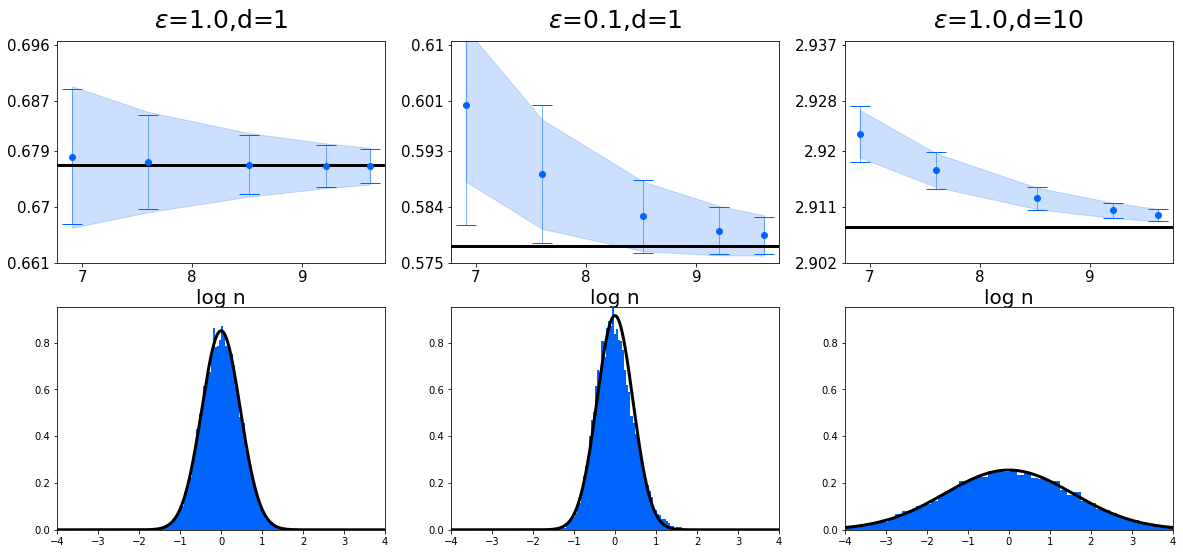

In [7]:
#Create Figure 1


fig,ax = plt.subplots(2,3,figsize=(20,9))



minn = 2
ftick=15
n1= np.array(n_samples_vec[minn:])
n2 = n1 
n2 = n2.astype(int)

listd =[0,0,2]
listnl=[1,0,1]

valdelta =[[0.015,0.02], [0.002,0.033], [0.005,0.03],[0.005,0.001]]

for i in range(3):
    nl=listnl[i]
    d =listd[i]
    y = sink_ind_mean[1,minn:,d,nl]
    err2 = np.sqrt(ds[d]*0.5/n2)
    err = np.nanstd(sink_ind[:,minn:,1,d,nl],0)
    ax[0,i].errorbar(np.log(n_samples_vec[minn:]),np.log(y),np.log((err+y)/y),fmt='o', linewidth=lw, color=csink_ind1,capsize=10,elinewidth=0.5)
    ax[0,i].fill_between(np.log(n_samples_vec[minn:]), np.log(y-err2), np.log(y+err2),color=csink_ind1,alpha=0.2)
    
    mu0 = np.tile(np.array([-1, 1]), [ds[d], 1]).T
    
    val = entropy_mixture(mu0, noise_levels[nl]+noise_base, 5000000)
    var = -1*entropy_mixture(mu0, noise_levels[nl]+noise_base, 5000000, power=2.0)-val**2
    
    ax[0,i].axhline(np.log(val),color=[0.0,0.0,0.0], linewidth=lwb)
    valint = [np.log(val)-valdelta[i][0], np.log(val)+valdelta[i][1]]
    ax[0,i].set_ylim(valint)
    
    #histogram with only the highest number of iterations
    n=-1
    data = sink_ind[:,n,1,d,nl]
    fac = np.sqrt(n1[-1]*n2[-1]/(n1[-1]+n2[-1]))
    centered = (data- np.nanmean(data))*fac
    sigma = (n1[-1]+0.0)/(n1[-1]+n2[-1]+0.0)*var
    

    y_ticks = np.floor(1000*np.linspace(valint[0], valint[1],5))/1000
    x_ticks =[7,8,9]
    x_tickslabels = [7,8,9]
    ax[0,i].set_ylim(valint)
    ax[0,i].set_yticks(y_ticks)
    ax[0,i].set_yticklabels(y_ticks,fontsize=ftick)
    ax[0,i].set_xticks(x_ticks)
    ax[0,i].set_xticklabels(x_tickslabels,fontsize=ftick)
    ax[0,i].set_title('$\epsilon$=' + str(noise_levels[nl])+',d='+ str(ds[d]),fontsize=25,y=1.03)
    ax[0,i].set_xlabel('log n', fontsize=20)
    maxx=4
    array_x = np.linspace(-maxx,maxx,1000)
    dens = 1.0/((2*np.pi*sigma))**0.5 *np.exp(-array_x**2.0/(2*sigma))

    ax[1,i].hist(centered[~np.isnan(centered)],bins=75,density=True,alpha=1.0,color=csink_ind1)
    ax[1,i].plot(array_x,dens, color = [0.0, 0.0, 0.0], linewidth=lwb)
    ax[1,i].set_ylim([0,0.95])
    ax[1,i].set_xlim([-4.0,4.0])
    
    vals = np.array([np.min(y-err), val, np.max(y+err)])

plt.savefig('clt.png')
      

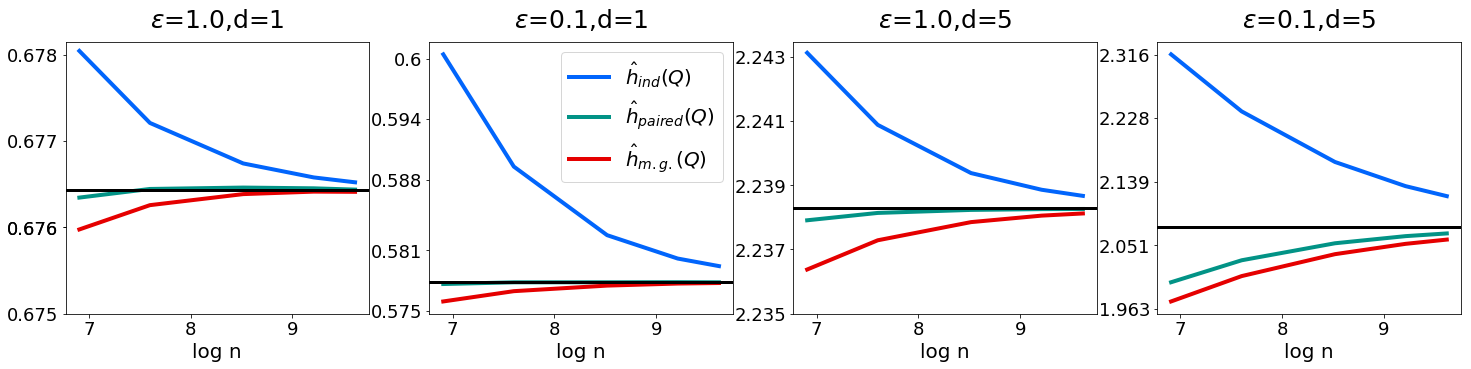

In [16]:
#Create figure 2


fig, ax = plt.subplots(1,4, figsize =(25,5))
ftick = 18
#list of data to plot
listd =[0,0,1,1]
listnl=[1,0,1,0]
win1 = np.array([0.0001,0.0015])
valdelta =[win1, 1*win1, 10*win1, 100*win1]
for i in range(len(listnl)):
    nl=listnl[i]
    d =listd[i]
    

    ax[i].plot(np.log(n_samples_vec[minn:]),np.log(sink_ind_mean[1,minn:,d,nl]), linewidth=lw, color=csink_ind1)
    ax[i].plot(np.log(n_samples_vec[minn:]),np.log(sink_mean[1,minn:,d,nl]), linewidth=lw, color =csink)
    ax[i].plot(np.log(n_samples_vec[minn:]),np.log(MC_mean[1,minn:,d,nl]), linewidth=lw,color=cent)
    
    val = ds[d]*0.5*np.log(2*np.pi*np.exp(1.0)*(noise_levels[nl]+noise_base))
    mu0 = np.tile(np.array([-1, 1]), [ds[d], 1]).T
    val = entropy_mixture(mu0, noise_levels[nl]+noise_base, 100000000)
   

    ax[i].axhline(np.log(val),color=[0.0,0.0,0.0], linewidth=lwb)
    ax[i].set_title('$\epsilon$=' + str(noise_levels[nl])+',d='+ str(ds[d]),fontsize=25,y=1.03)
    valint = [np.log(MC_mean[1,minn,d,nl])-valdelta[i][0], np.log(sink_ind_mean[1,minn,d,nl])]
     
    y_ticks = np.floor(1000*np.linspace(valint[0], valint[1],5))/1000
    x_ticks =[7,8,9]
    x_tickslabels = [7,8,9]

    ax[i].set_yticks(y_ticks)
    ax[i].set_yticklabels(y_ticks,fontsize=ftick)
    ax[i].set_xticks(x_ticks)
    ax[i].set_xticklabels(x_tickslabels,fontsize=ftick)
    ax[i].set_xlabel('log n', fontsize=20)
    
    if(i==1):
        ax[i].legend(['$\hat{h}_{ind}(Q)$','$\hat{h}_{paired}(Q)$','$\hat{h}_{m.g.}(Q)$'],fontsize=20)
plt.savefig('means.png')
                